**Symentic Search Using S bert Model**

In [ ]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.1 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=426b75d7bedc6e41e6f63c989a7798c84717c90d6401b2f1505aa3dff81ce2e3
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
     

Mounted at /content/drive


In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/dlops/wiki_movie_plots_deduped.csv',memory_map=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


In [ ]:
!nvidia-smi 

/bin/bash: nvidia-smi: command not found


In [ ]:
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

In [ ]:
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

In [ ]:
import gc
df = data[['Title','Plot']]
del data
gc.collect()

145

In [ ]:
df.dropna(inplace=True)
df.drop_duplicates(subset=['Plot'],inplace=True)

In [ ]:
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 12.0 MB/s eta 0:00:00


<ipython-input-11-be08a03964eb>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['doc_len'], hist=True, kde=True, color='b', label='doc len')


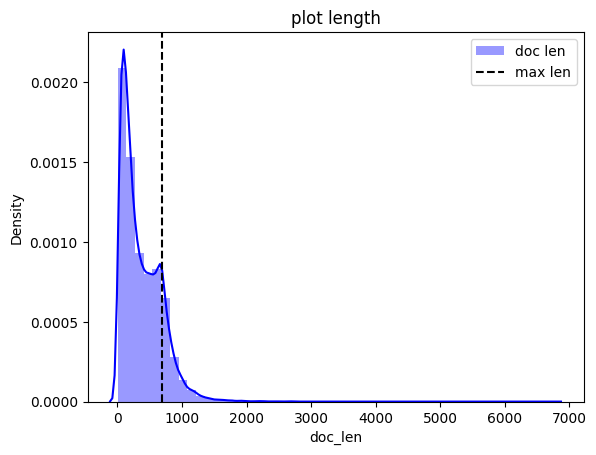

In [ ]:
df['doc_len'] = df['Plot'].apply(lambda words: len(words.split()))
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
sns.distplot(df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

In [ ]:
# import faiss
# encoded_data = model.encode(df.Plot.tolist())
# encoded_data = np.asarray(encoded_data.astype('float32'))
# index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
# index.add_with_ids(encoded_data, np.array(range(0, len(df))))
# faiss.write_index(index, 'movie_plot.index')

In [ ]:
import faiss

In [ ]:
index = faiss.read_index('/content/drive/MyDrive/dlops/movie_plot.index')

In [ ]:
def fetch_movie_info(dataframe_idx):
    info = df.iloc[dataframe_idx]
    meta_dict = {}
    meta_dict['Title'] = info['Title']
    return meta_dict
    
def search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_movie_info(idx) for idx in top_k_ids]
    return results

In [ ]:
from pprint import pprint

query="Artificial Intelligence based action movie"
results=search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

>>>> Results in Total Time: 0.17319607734680176


	 {'Title': 'The Cape Canaveral Monsters'}
	 {'Title': 'Small Soldiers'}
	 {'Title': 'Chappie'}
	 {'Title': 'Armed Response'}
	 {'Title': 'Galactic Armored Fleet Majestic Prince: Genetic Awakening'}


In [ ]:
from pprint import pprint

query="movie about romance and pain of separation"
results=search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',(result))
    

>>>> Results in Total Time: 0.06516551971435547


	 {'Title': 'Look Both Ways'}
	 {'Title': 'Young People Fucking'}
	 {'Title': 'About Love'}
	 {'Title': 'Brothers'}
	 {'Title': 'The Farm: En Veettu Thottathil'}


In [ ]:
from pprint import pprint

query="movie about romance and pain of separation"
results=search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',(result))

>>>> Results in Total Time: 0.06451296806335449


	 {'Title': 'Look Both Ways'}
	 {'Title': 'Young People Fucking'}
	 {'Title': 'About Love'}
	 {'Title': 'Brothers'}
	 {'Title': 'The Farm: En Veettu Thottathil'}


In [ ]:
paragraphs=df.Plot.tolist()

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
tokenizer = T5Tokenizer.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model = T5ForConditionalGeneration.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d

In [ ]:
# Parameters for generation
batch_size = 4 #Batch size
num_queries = 2 #Number of queries to generate for every paragraph
max_length_paragraph = 128 #Max length for paragraph
max_length_query = 20   #Max length for output query

In [ ]:
def _removeNonAscii(s): return "".join(i for i in s if ord(i) < 128)

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model.to(device)


T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d

In [ ]:
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets
from torch import nn
import os
import random

train_examples = [] 
with open('/content/drive/MyDrive/dlops/generated_queries_all.tsv') as fIn:
    for line in fIn:
        try:
            query, paragraph = line.strip().split('\t', maxsplit=1)
            train_examples.append(InputExample(texts=[query, paragraph]))
        except:
            pass
        
random.shuffle(train_examples)

# For the MultipleNegativesRankingLoss, it is important  that the batch does not contain duplicate entries, i.e.
# no two equal queries and no two equal paragraphs  To ensure this, we use a special data loader
train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size=8)

# Now we create a SentenceTransformer model from scratch
word_emb = models.Transformer('sentence-transformers/msmarco-distilbert-base-dot-prod-v3')
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_emb, pooling])


# MultipleNegativesRankingLoss requires input pairs (query, relevant_passage)
# and trains the model so that is is suitable for semantic search
train_loss = losses.MultipleNegativesRankingLoss(model)


#Tune the model
num_epochs = 3
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=num_epochs, warmup_steps=warmup_steps, show_progress_bar=True)

os.makedirs('search', exist_ok=True)
model.save('search/search-model')


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration: 0it [00:00, ?it/s]

Iteration: 0it [00:00, ?it/s]

Iteration: 0it [00:00, ?it/s]

In [ ]:
from pprint import pprint

query="Artificial Intelligence based action movie"
results=search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

>>>> Results in Total Time: 0.087249755859375


	 {'Title': "Don's Fountain of Youth"}
	 {'Title': 'Outcasts of the City'}
	 {'Title': 'Cafe Colette'}
	 {'Title': 'Adventure of the King'}
	 {'Title': 'Your Name'}


In [ ]:
!pip install sentence-transformers
!pip install faiss-cpu

from sentence_transformers import SentenceTransformer, InputExample, datasets
import faiss
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# Loading pre-trained model
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

# Loading Faiss index
index = faiss.read_index('/content/drive/MyDrive/dlops/movie_plot.index')

def search(query):
    # Encoding query
    query_embedding = model.encode(query)
    query_embedding = np.asarray(query_embedding.astype('float32')).reshape(1, -1)
    
    # Performing search on index
    D, I = index.search(query_embedding, k=5)
    
    # Getting the top results
    results = []
    for idx, score in zip(I[0], D[0]):
        results.append({'score': score, 'plot': df.iloc[idx]['Plot']})
    
    return results



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 86.6 MB/s eta 0:00:00


In [ ]:
# Modifying fetch_movie_info function to return score, plot, and title
def fetch_movie_info(dataframe_idx, score):
    info = df.iloc[dataframe_idx]
    meta_dict = {'Title': info['Title'], 'Plot': info['Plot'], 'Score': score}
    return meta_dict

# Modifying search function to include score and plot in results
def search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_scores = top_k[0].tolist()[0]  # Scores for the top k results
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_movie_info(idx, score) for idx, score in zip(top_k_ids, top_k_scores)]
    return results


In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Define UI elements
query_input = widgets.Text(placeholder='Enter query here')
search_button = widgets.Button(description='Search')
output = widgets.Output()

# Define search function for button click
def on_search_button_click(b):
    with output:
        output.clear_output()
        results = search(query_input.value, top_k=5, index=index, model=model)
        for result in results:
            print(f"Title: {result['Title']}")
            print(f"Score: {result['Score']}")
            print(f"Plot: {result['Plot']}")
            print()

# Add event listener for button click
search_button.on_click(on_search_button_click)

# Display UI
display(query_input)
display(search_button)
display(output)


Text(value='', placeholder='Enter query here')

Button(description='Search', style=ButtonStyle())

Output()